# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [ ]:
!g++ -o ./exe_bin/tp_openmp_part_1_pi_sequential ./Part_1/tp_openmp_part_1_pi_sequential.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_reduce ./Part_1/tp_openmp_part_1_pi_impl_reduce.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_atomic ./Part_1/tp_openmp_part_1_pi_impl_atomic.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_critical ./Part_1/tp_openmp_part_1_pi_impl_critical.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_split_array ./Part_1/tp_openmp_part_1_pi_impl_split_array.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [ ]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

num_steps = [1000, 1000000]#, 100000000, 10000000000, 1000000000000]
nb_core = [1, 2, 4, 8]
repeats = range(0,10)
executables = ['tp_openmp_part_1_pi_sequential', 'tp_openmp_part_1_pi_impl_reduce', 'tp_openmp_part_1_pi_impl_atomic', 'tp_openmp_part_1_pi_impl_critical', 'tp_openmp_part_1_pi_impl_split_array']

for nsteps in num_steps:
    for ncore in nb_core:
        for repeat in repeats:
            for executable in executables:
                args = ("./" + executable, "-C", str(ncore), "-N", str(nsteps))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                try:
                    out, err = popen.communicate(timeout=1)
                except Exception:
                    out = b''
                if isinstance(out, bytes):
                    out = out.decode(errors='ignore')

                m = re.search(r'pi with\s+(\d+)\s+steps is\s+([0-9.+-eE]+)\s+in\s+([0-9.+-eE]+)\s+seconds', out)
                if m:
                    pi_val = m.group(2)
                    time_s = m.group(3)
                else:
                    # fallback: use last non-empty line of stdout
                    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                    last = lines[-1] if lines else ''
                    pi_val = ''
                    time_s = ''
                    # try to extract numbers from last line if possible
                    m2 = re.search(r'([0-9.+-eE]+).*in.*([0-9.+-eE]+)\s*seconds', last)
                    if m2:
                        pi_val = m2.group(1)
                        time_s = m2.group(2)

                # one-line summary
                print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")



tp_openmp_part_1_pi_sequential | cores=1 | steps=1000 | repeat=0 | rc=0 | pi=3.141593 | time_s=0.000001
tp_openmp_part_1_pi_impl_reduce | cores=1 | steps=1000 | repeat=0 | rc=0 | pi=3.141593 | time_s=0.000008
tp_openmp_part_1_pi_impl_atomic | cores=1 | steps=1000 | repeat=0 | rc=0 | pi=3.141593 | time_s=0.000017
tp_openmp_part_1_pi_impl_critical | cores=1 | steps=1000 | repeat=0 | rc=0 | pi=3.141593 | time_s=0.000019
tp_openmp_part_1_pi_impl_split_array | cores=1 | steps=1000 | repeat=0 | rc=0 | pi=3.141593 | time_s=0.000009
tp_openmp_part_1_pi_sequential | cores=1 | steps=1000 | repeat=1 | rc=0 | pi=3.141593 | time_s=0.000001
tp_openmp_part_1_pi_impl_reduce | cores=1 | steps=1000 | repeat=1 | rc=0 | pi=3.141593 | time_s=0.000008
tp_openmp_part_1_pi_impl_atomic | cores=1 | steps=1000 | repeat=1 | rc=0 | pi=3.141593 | time_s=0.000017
tp_openmp_part_1_pi_impl_critical | cores=1 | steps=1000 | repeat=1 | rc=0 | pi=3.141593 | time_s=0.000019
tp_openmp_part_1_pi_impl_split_array | cores=1 |

### Performance analysis
#### Weak scaling

No handles with labels found to put in legend.


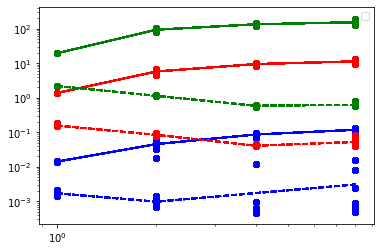

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('stats.csv',header=None,names=['version','nbcore','num_steps','runtime'],dtype={
                     'version': str,
                     'nbcore': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {1000000 : "blue", 100000000 : "red", 10000000000 : "green", 1000000000000 : "black"}

for num_steps in df['num_steps']:
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "atomic"]
    
    mean_stats = df_plot.groupby(['num_steps','version','nbcore']).mean().reset_index()
    
    plt.plot(mean_stats['nbcore'], mean_stats['runtime'],linestyle="solid",color=color_num_steps[num_steps])
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nbcore'], df_plot['runtime'],color=color_num_steps[num_steps])

    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nbcore']).mean().reset_index()
    
    plt.plot(mean_stats['nbcore'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps])
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nbcore'], df_plot['runtime'],color=color_num_steps[num_steps])
    
plt.legend()
plt.show()

#### Strong Scaling

### Discussion